## Setup and Preprocessing
### Import Required Packages

In [1]:
import glob
import numpy as np
import pandas as pd
import cv2 as cv
import os
import glob
import random
from PIL import Image

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import torch

from transformers import AutoFeatureExtractor, AutoModelForImageClassification

from utils import *

In [2]:
classN_img_path = "Data/train/normal"
classA_img_path = "Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"
classL_img_path = "Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa"
classS_img_path = "Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"

image_paths = {"normal": classN_img_path, 
               "adenocarcinoma": classA_img_path,
               "large_cell_carcinoma": classL_img_path, 
               "squamous_cell_carcinoma": classS_img_path}

train_and_valid_class_mappings = {
    0: "normal",
    1: "adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib",
    2: "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa",
    3: "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"
}

test_class_mappings = {
    0: "normal",
    1: "adenocarcinoma",
    2: "large.cell.carcinoma",
    3: "squamous.cell.carcinoma"
}

In [ ]:
normal_example_path = classN_img_path + "/10.png"
adenocarcinoma_example_path = classA_img_path + "/ad4.png"
large_cell_carcinoma_example_path = classL_img_path + "/000002.png"
squamous_cell_carcinoma_example_path = classS_img_path + "/000003.png"

def plot_imgs(imN, imA, imL, imS):
    # display the points
    fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
    ax[0][0].imshow(imN, cmap='gray')
    ax[0][0].set_title("Normal (N)")

    ax[0][1].imshow(imA, cmap='gray')
    ax[0][1].set_title("Adenocarcinoma (A)")

    ax[1][0].imshow(imL, cmap='gray')
    ax[1][0].set_title("Large cell carcinoma (L)")

    ax[1][1].imshow(imS, cmap='gray')
    ax[1][1].set_title("Squamous cell carcinoma (S)")
    plt.show()
    
imN = plt.imread(normal_example_path)
imA = plt.imread(adenocarcinoma_example_path)
imL = plt.imread(large_cell_carcinoma_example_path)
imS = plt.imread(squamous_cell_carcinoma_example_path)
plot_imgs(imN, imA, imL, imS)

In [4]:
crop_and_resize_images("Data/train", train_and_valid_class_mappings, (256,256), 'Data_cropped_and_resized')

In [5]:
crop_and_resize_images("Data/valid", train_and_valid_class_mappings, (256,256), 'Data_cropped_and_resized')

In [6]:
crop_and_resize_images("Data/test", test_class_mappings, (256,256), 'Data_cropped_and_resized')

## Histogram Equalization

In [7]:
equalize_images("Data_cropped_and_resized/train", train_and_valid_class_mappings, 'Data_cropped_resized_equalized')
equalize_images("Data_cropped_and_resized/valid", train_and_valid_class_mappings, 'Data_cropped_resized_equalized')
equalize_images("Data_cropped_and_resized/test", test_class_mappings, 'Data_cropped_resized_equalized')



In [8]:
from skimage import io
def plot_img_and_hist(image, axes, title, bins=256):
    """ 
    Plot an image along with its histogram and cumulative histogram
    """

    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax_img.set_axis_off()
    ax_img.set_title(title)

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_cdf
    

def display_images(orig, hist_eq):
    """
    Plot the original image and all three modified images
    along with their histograms
    """
    
    orig = io.imread(orig)
    hist_eq = io.imread(hist_eq)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

    # plot original
    plot_img_and_hist(orig, axes[:, 0], title='Original Image')

    # set left y-axis label
    y_min, y_max = axes[1, 0].get_ylim()
    axes[1, 0].set_ylabel('Number of pixels')
    axes[1, 0].set_yticks(np.linspace(0, y_max, 5))

    # plot modifications
    ax_cdf = plot_img_and_hist(hist_eq, axes[:, 1], title='Histogram Equalization')

    # set right y-axis label
    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()


In [9]:
display_images("Data/train/normal/10.png","Data_cropped_resized_equalized/train/normal/10.png")


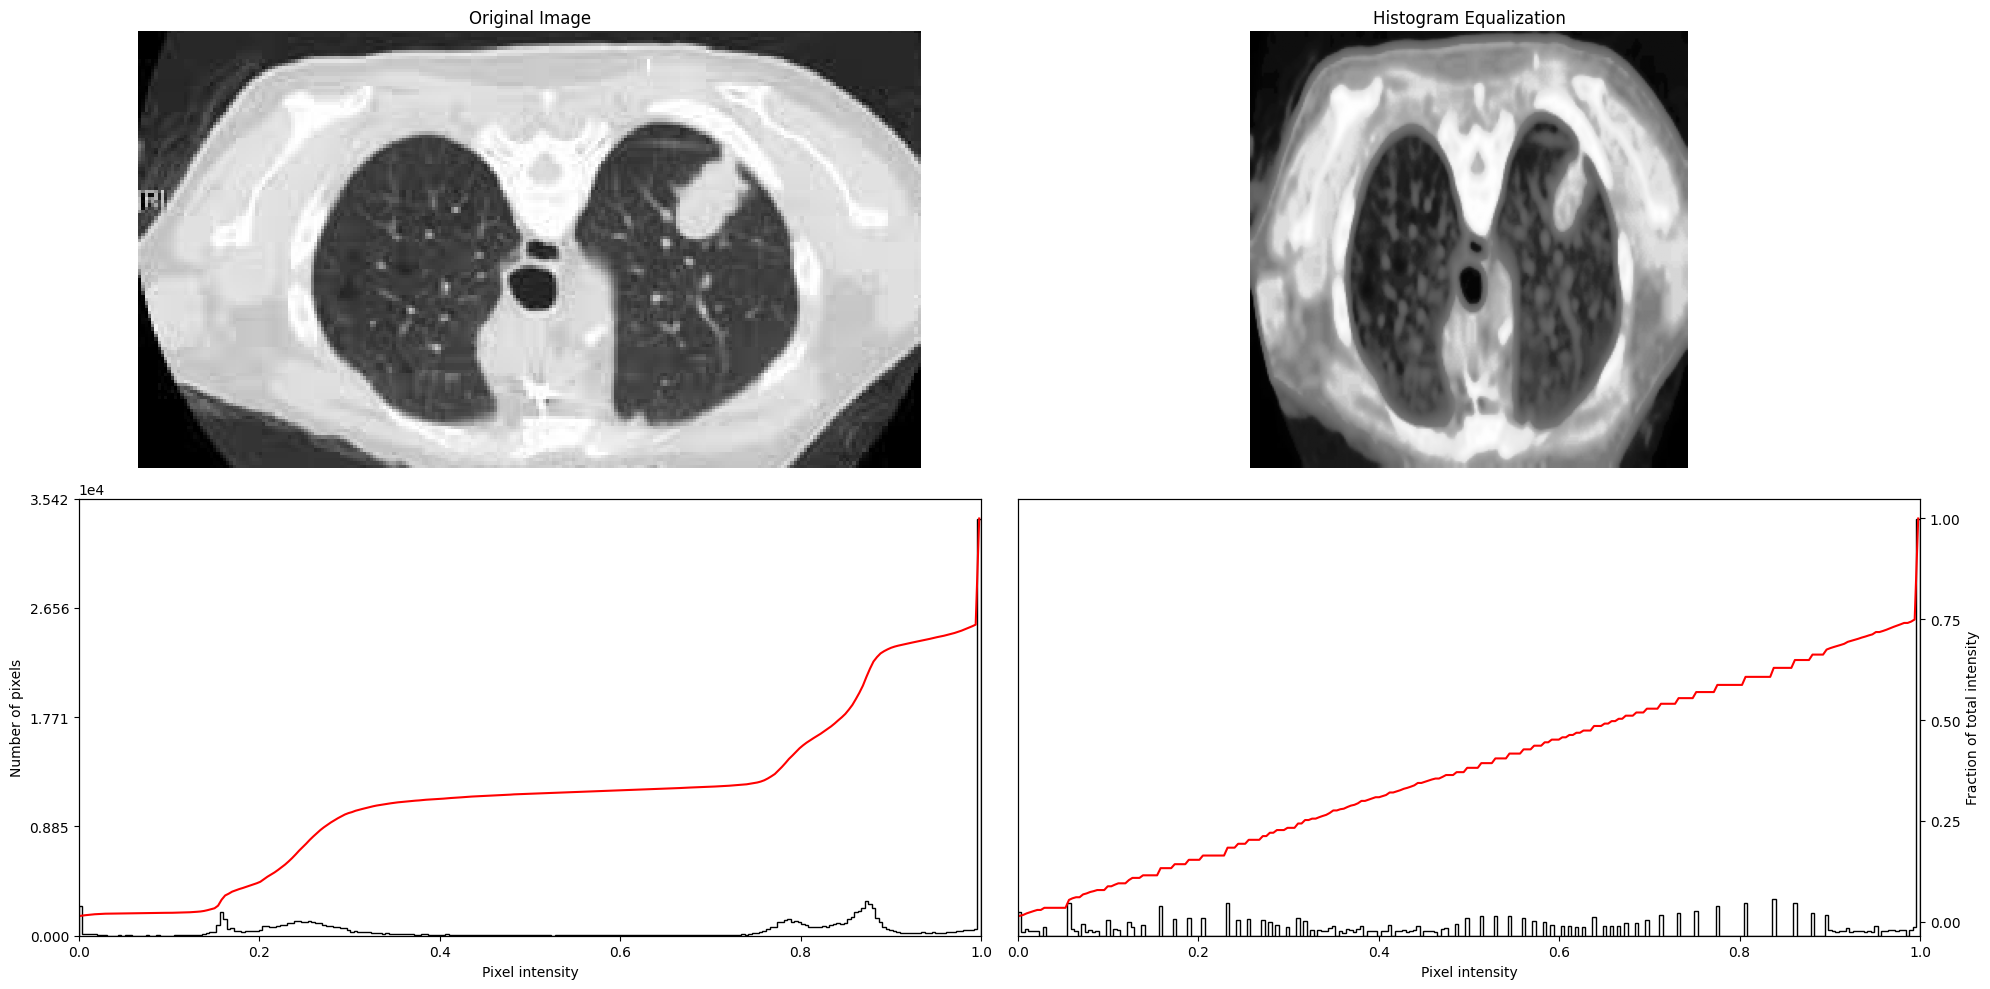

In [10]:
display_images("Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/ad4.png",
               "Data_cropped_resized_equalized/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/ad4.png")


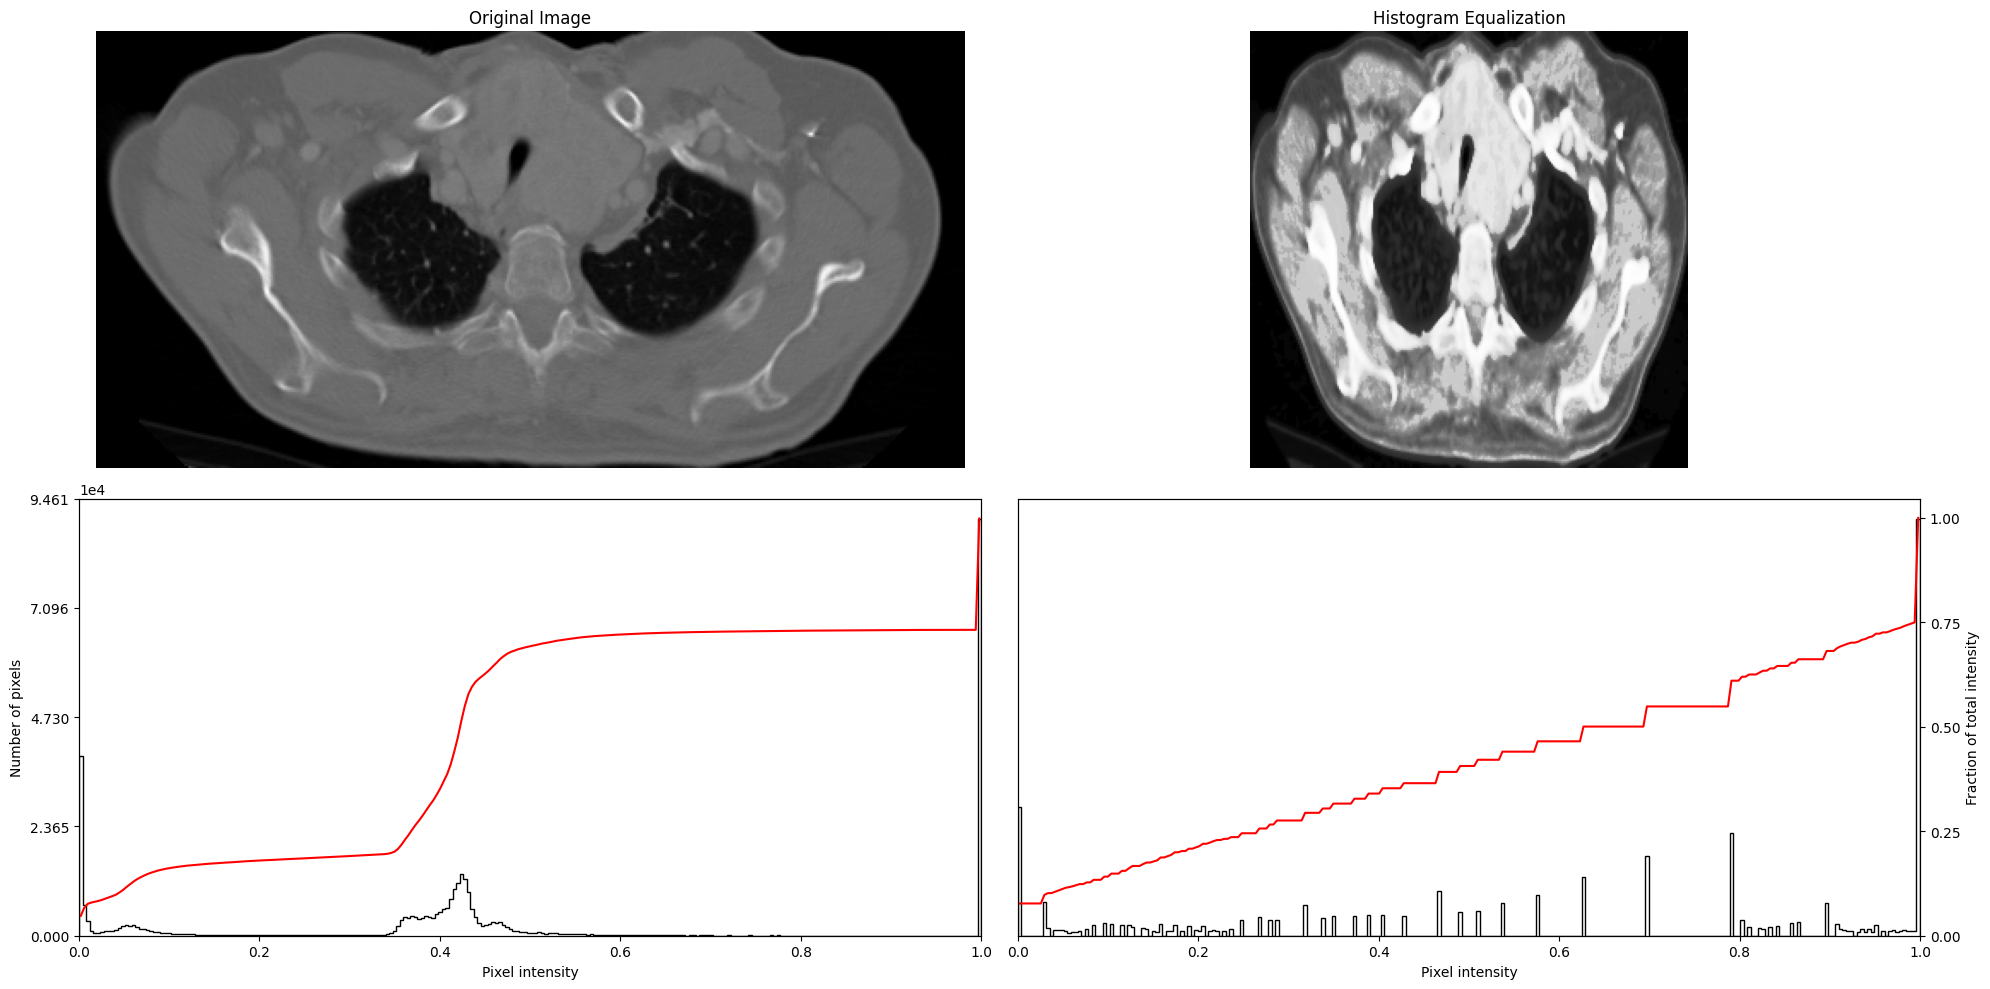

In [11]:
display_images("Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000002.png",
               "Data_cropped_resized_equalized/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000002.png")


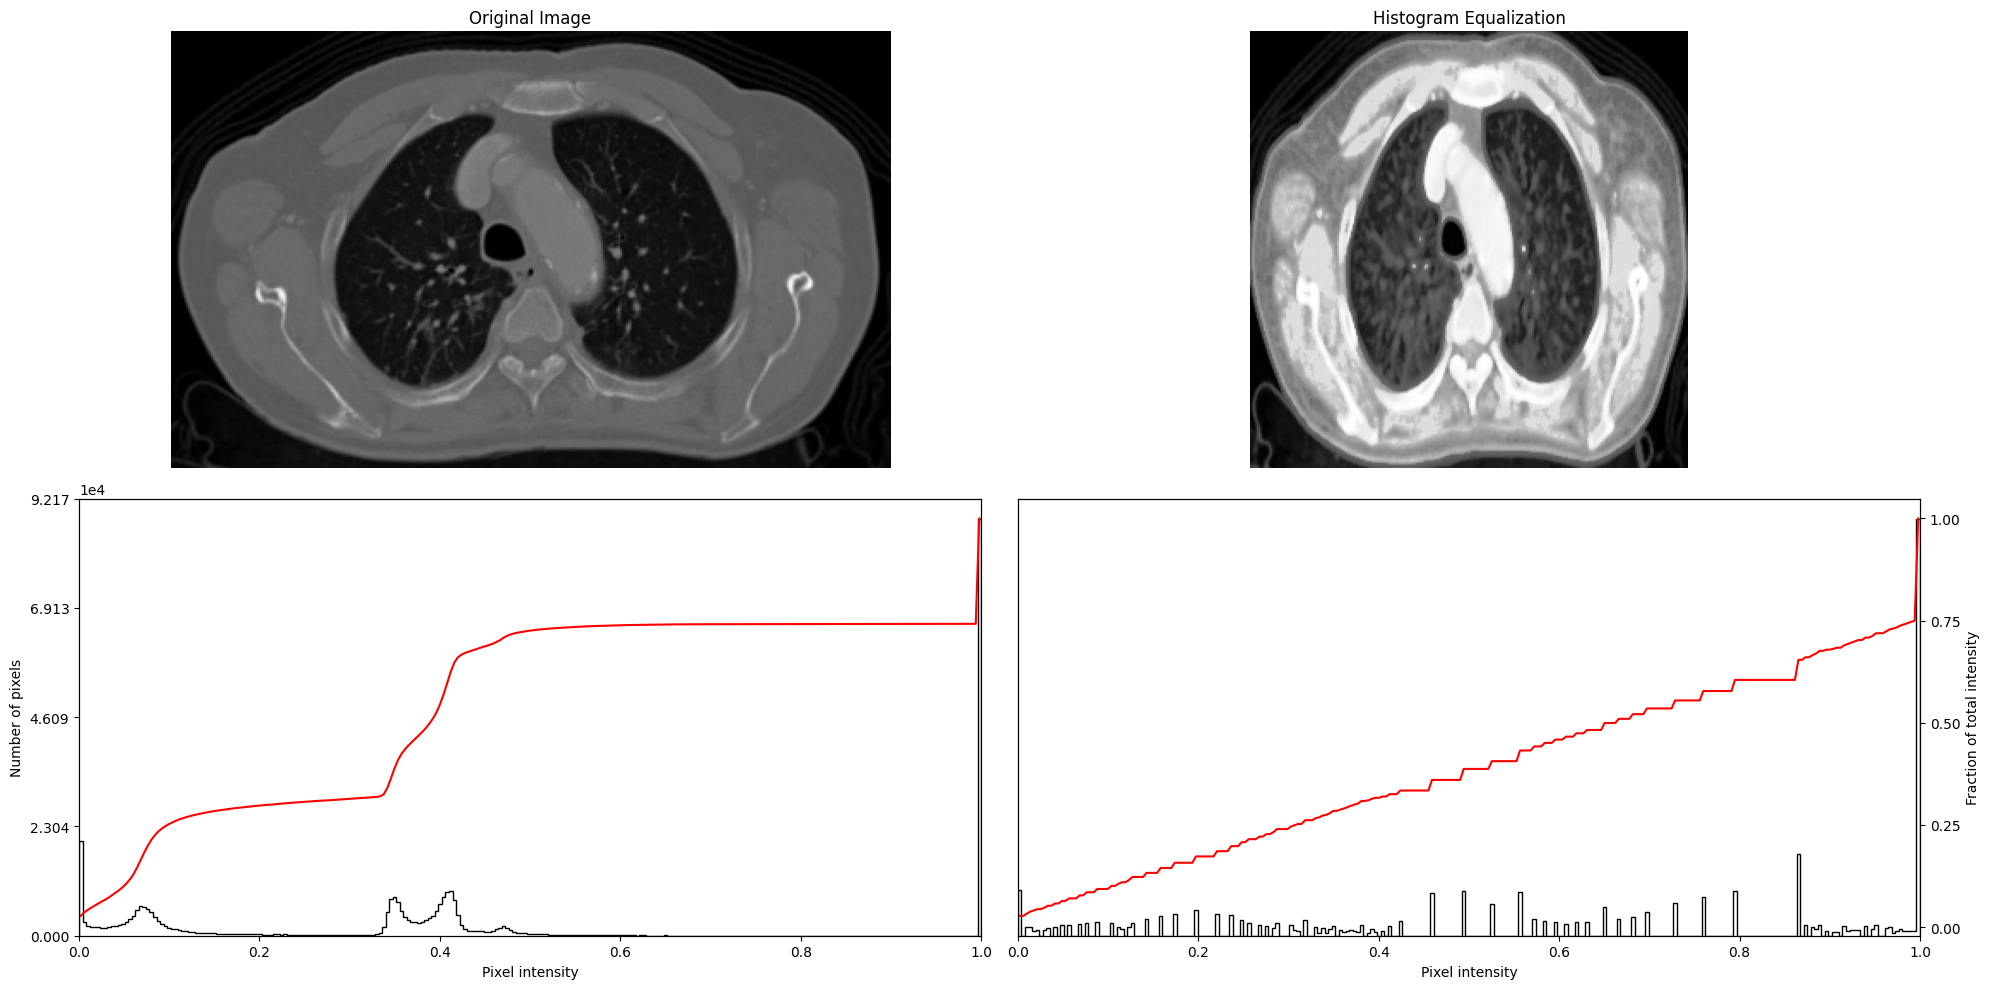

In [12]:
display_images("Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000003.png",
               "Data_cropped_resized_equalized/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000003.png")


## Feature Extraction

### Simple Feature Extraction

In [7]:
train_path = "Data_cropped_resized_equalized/train"
valid_path = "Data_cropped_resized_equalized/valid/"


train_canny_edge_images, train_canny_edges, train_canny_labels = extract_features(train_path, 
                                           detect_canny_edges, 
                                           train_and_valid_class_mappings)

_, valid_canny_edges, valid_canny_labels = extract_features(valid_path, 
                                           detect_canny_edges, 
                                           train_and_valid_class_mappings)

train_sobel_edge_images, train_sobel_edges, train_sobel_labels = extract_features(train_path, 
                                                                                  detect_edges_sobel,
                                                                                  train_and_valid_class_mappings)

_, valid_sobel_edges, valid_sobel_labels = extract_features(valid_path,
                                                            detect_edges_sobel,
                                                            train_and_valid_class_mappings)

train_soft_tissue_images, train_soft_tissue, train_soft_tissue_labels = extract_features(train_path, get_soft_tissue, train_and_valid_class_mappings)
_, valid_soft_tissue, valid_soft_tissue_labels = extract_features(valid_path, get_soft_tissue, train_and_valid_class_mappings)



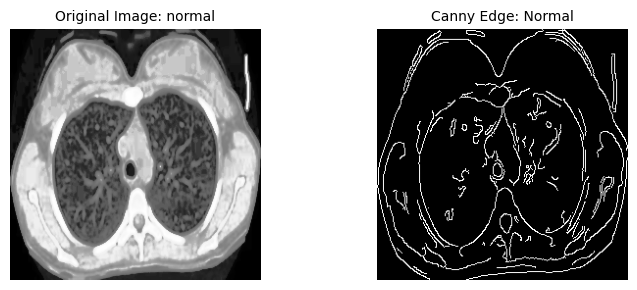

In [31]:
plot_features(train_canny_edge_images, 
              train_canny_edges, 
              train_canny_labels, 
              0, 
              'Canny Edge: Normal',
              test_class_mappings)
plot_features(train_canny_edge_images, 
              train_canny_edges, 
              train_canny_labels, 
              1, 
              'Canny Edge: Adenocarcinoma',
              test_class_mappings)
plot_features(train_canny_edge_images, 
              train_canny_edges, 
              train_canny_labels, 
              2, 
              'Canny Edge: Large Cell Carcinoma',
              test_class_mappings)
plot_features(train_canny_edge_images, 
              train_canny_edges, 
              train_canny_labels, 
              2, 
              'Canny Edge: Squamous Cell Carcinoma',
              test_class_mappings)


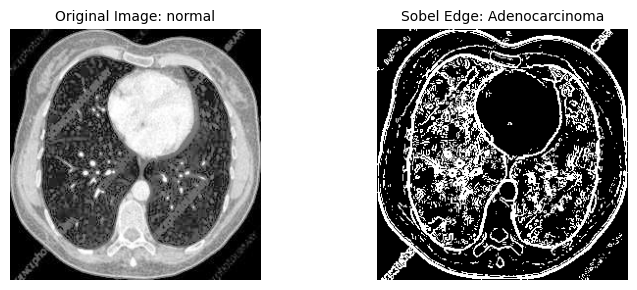

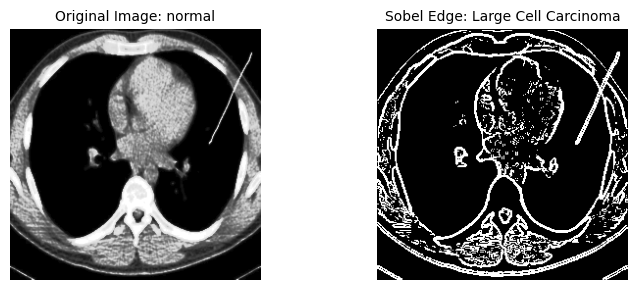

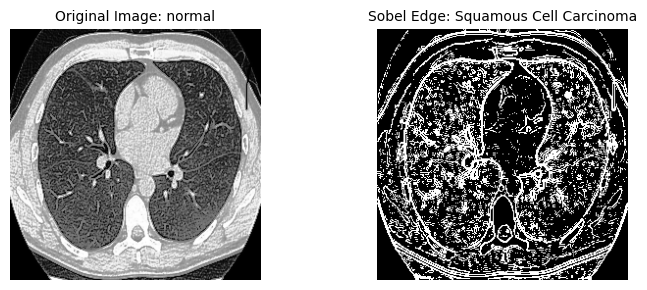

In [32]:
plot_features(train_sobel_edge_images, 
              train_sobel_edges, 
              train_sobel_labels, 
              0, 
              'Sobel Edge: Normal',
              test_class_mappings)
plot_features(train_sobel_edge_images, 
              train_sobel_edges, 
              train_sobel_labels, 
              1, 
              'Sobel Edge: Adenocarcinoma',
              test_class_mappings)
plot_features(train_sobel_edge_images, 
              train_sobel_edges, 
              train_sobel_labels, 
              2, 
              'Sobel Edge: Large Cell Carcinoma',
              test_class_mappings)
plot_features(train_sobel_edge_images, 
              train_sobel_edges, 
              train_sobel_labels, 
              3, 
              'Sobel Edge: Squamous Cell Carcinoma',
              test_class_mappings)


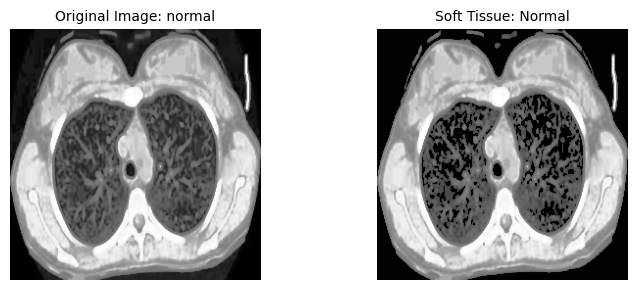

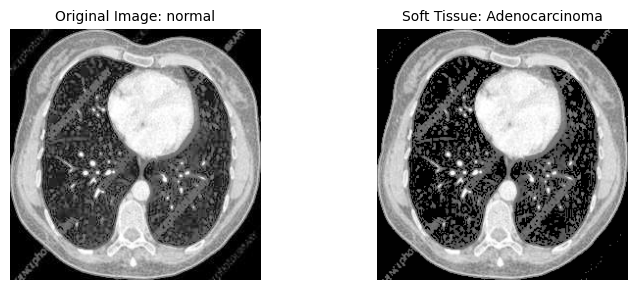

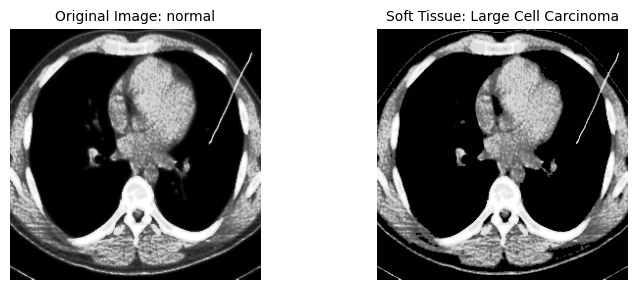

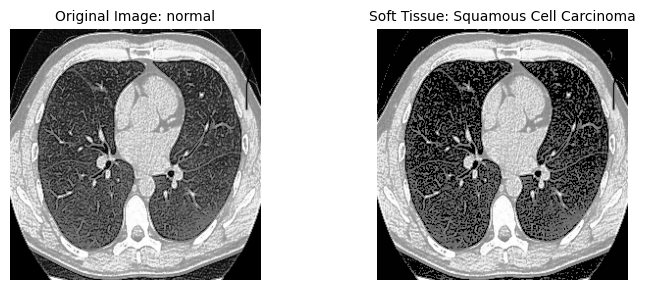

In [33]:
plot_features(train_soft_tissue_images, 
              train_soft_tissue, 
              train_soft_tissue_labels, 
              0, 
              'Soft Tissue: Normal',
              test_class_mappings)
plot_features(train_soft_tissue_images, 
              train_soft_tissue, 
              train_soft_tissue_labels, 
              1, 
              'Soft Tissue: Adenocarcinoma',
              test_class_mappings)
plot_features(train_soft_tissue_images, 
              train_soft_tissue, 
              train_soft_tissue_labels, 
              2, 
              'Soft Tissue: Large Cell Carcinoma',
              test_class_mappings)
plot_features(train_soft_tissue_images, 
              train_soft_tissue, 
              train_soft_tissue_labels, 
              3, 
              'Soft Tissue: Squamous Cell Carcinoma',
              test_class_mappings)

### Complex Feature Extraction using Neural Nets

In [4]:
extractor = AutoFeatureExtractor.from_pretrained("DunnBC22/vit-base-patch16-224-in21k_covid_19_ct_scans")
model = AutoModelForImageClassification.from_pretrained("DunnBC22/vit-base-patch16-224-in21k_covid_19_ct_scans")
model.eval()

/Users/zacharyzimmerman/Desktop/MIDS 281/mids-281-final-project/venv/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [5]:
def transformer_feature_vector(image, model=model, extractor=extractor):
    # Preprocess the image using the feature extractor
    image = Image.fromarray(image).convert('RGB')
    inputs = extractor(images=image, return_tensors="pt")
    # Forward pass through the model's transformer (without the classification head)
    with torch.no_grad():
        feature_vector = model.vit(**inputs).last_hidden_state
    # Optionally, convert to a NumPy array
    feature_vector = feature_vector.numpy()

    return feature_vector

In [8]:
train_transformer_images, train_transformer_features, train_transformer_labels = extract_features(train_path, 
                                                transformer_feature_vector, 
                                                train_and_valid_class_mappings)

valid_transformer_images, valid_transformer_features, valid_transformer_labels = extract_features(train_path, 
                                                transformer_feature_vector, 
                                                train_and_valid_class_mappings)




## PCA Decomposition and tSNE visualization

In [22]:
def get_PCA(X_list, n_components=2):
    pca_list = []
    xpca_list = []
    for X in X_list:
        pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(X)
        X_pca = pca.transform(X)
        pca_list.append(pca)
        xpca_list.append(X_pca)

    return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
    pca_list, xpca_list = get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'm-', 'g-', 'r-']
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
    plt.xticks(np.arange(n_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.show()

def get_tsne(X_list, n_components=2):
    xtsne_list = []
    for X in X_list:
        tsne = TSNE(n_components=n_components, random_state=0)
        X_tsne = tsne.fit_transform(X)
        xtsne_list.append(X_tsne)
    return xtsne_list

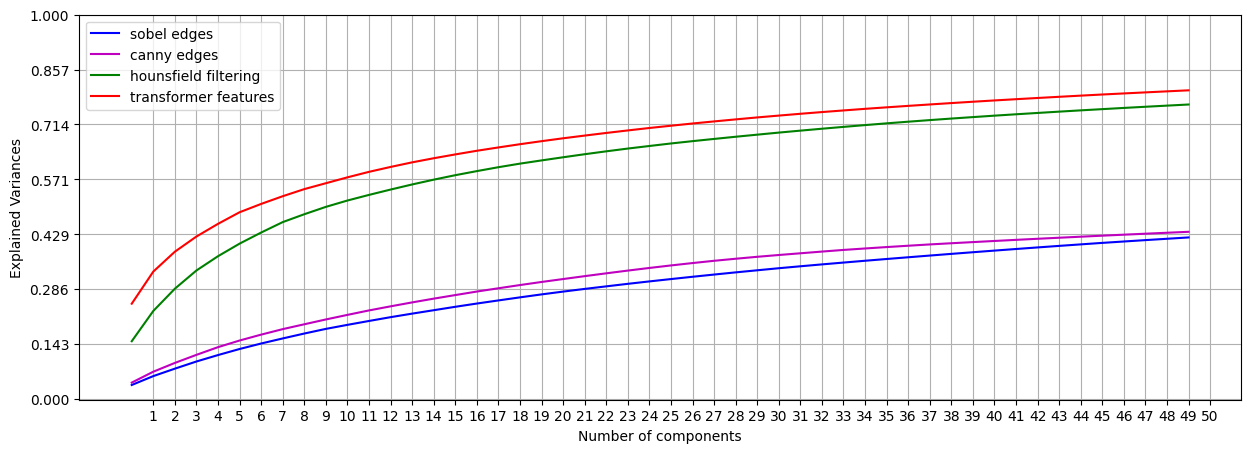

In [40]:
labels = ['sobel edges', 'canny edges', 'hounsfield filtering', 'transformer features']

training_features = [[img.flatten() for img in train_sobel_edges],
                    [img.flatten() for img in train_canny_edges],
                    [img.flatten() for img in train_soft_tissue],
                    [img.flatten() for img in train_transformer_features]]

plot_PCA(training_features, labels, n_components=50)

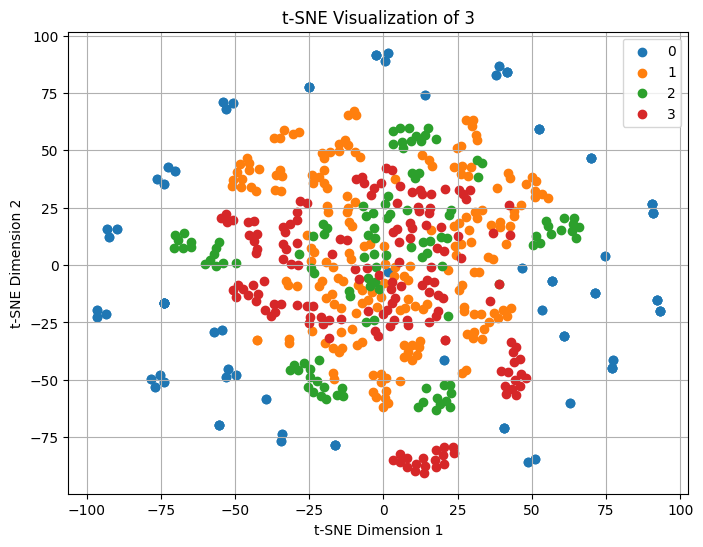

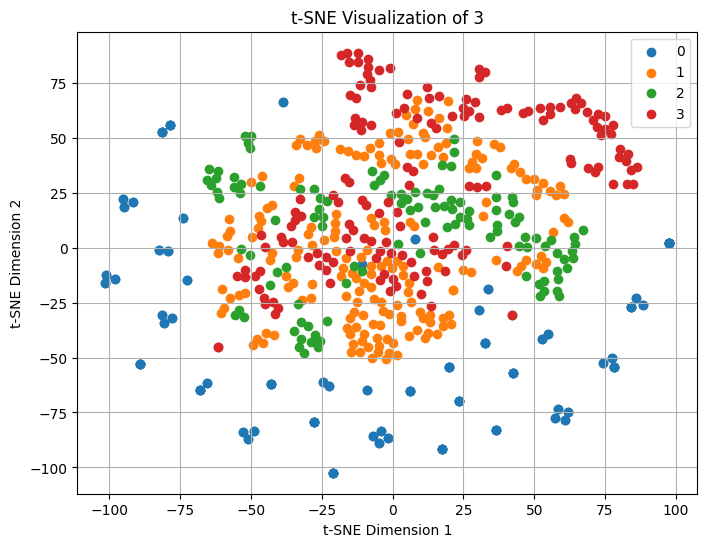

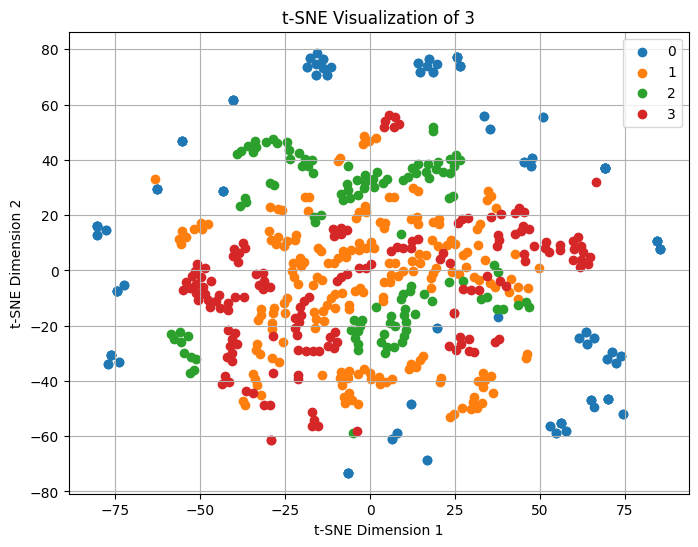

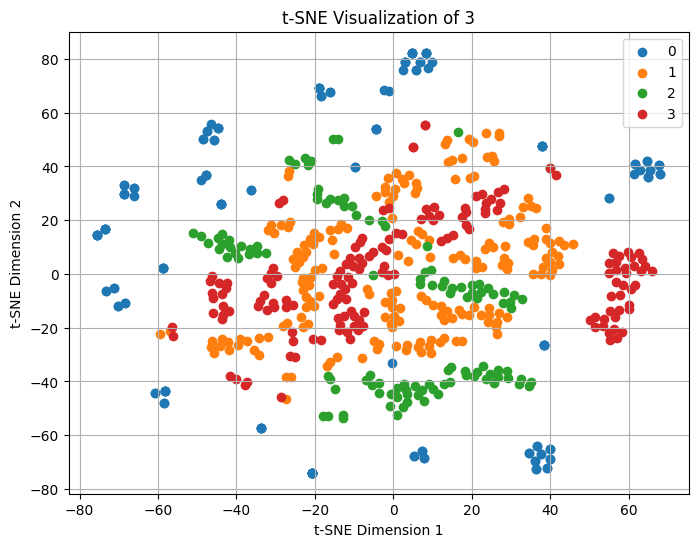

In [42]:
pca_list, xpca_list = get_PCA(training_features, n_components=49)

x_tsne_list = get_tsne(xpca_list)


for X_tsne, label in zip(x_tsne_list, labels):

    plt.figure(figsize=(8, 6))

    for label in np.unique(train_sobel_labels):
        plt.scatter(X_tsne[train_sobel_labels == label, 0], X_tsne[train_sobel_labels == label, 1], label=label)

    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f't-SNE Visualization of {label}')
    plt.legend()
    plt.grid(True)
    plt.show()

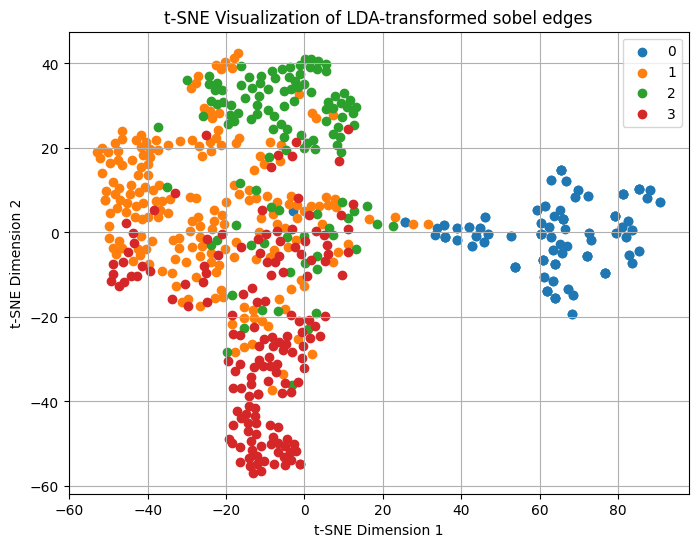

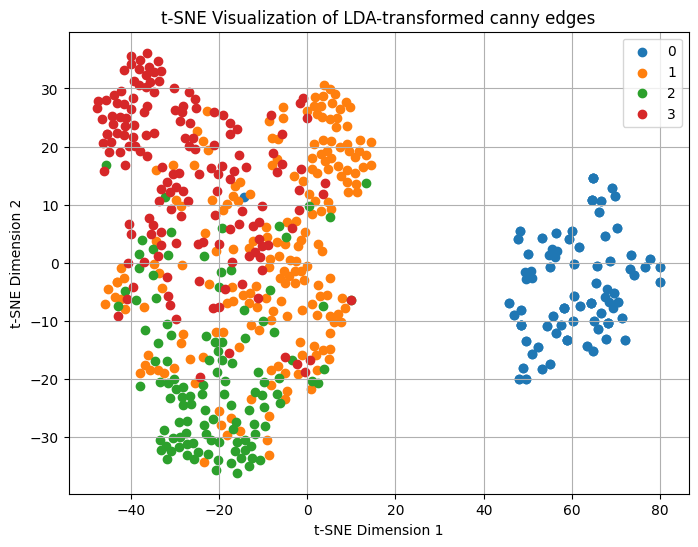

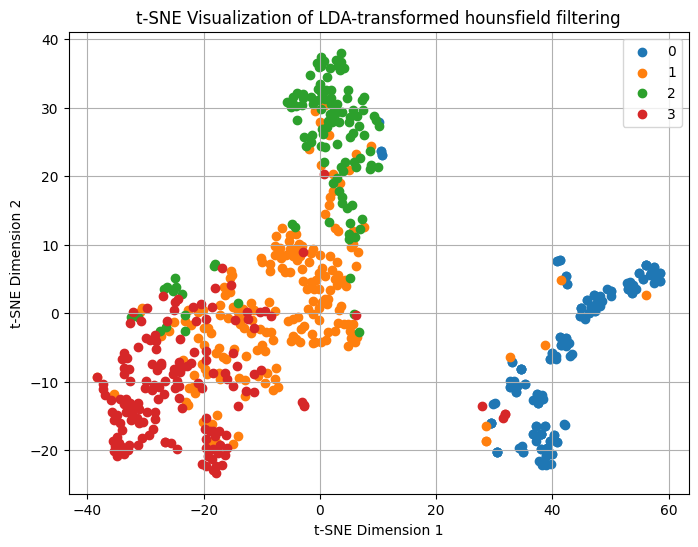

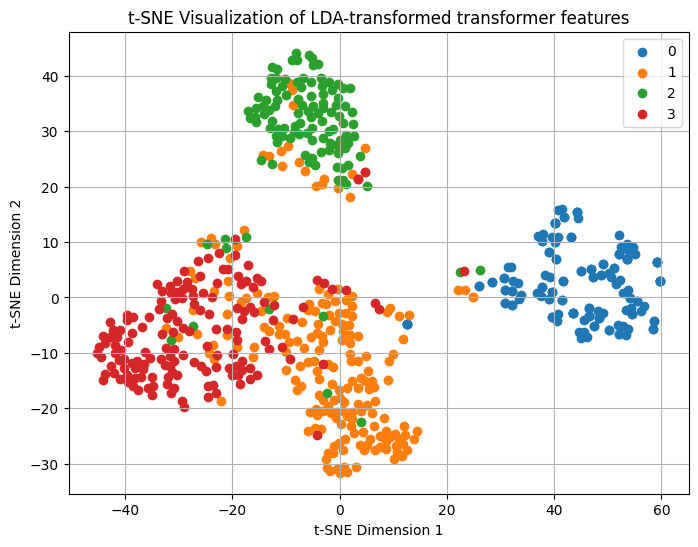

In [45]:
lda = LinearDiscriminantAnalysis()

for X_pca, transform_type in zip(xpca_list, labels):
    lda.fit(X_pca, train_sobel_labels)

    X_lda = lda.transform(X_pca)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_lda)

    plt.figure(figsize=(8, 6))

    for label in np.unique(train_sobel_labels):
        plt.scatter(X_tsne[train_sobel_labels == label, 0], X_tsne[train_sobel_labels == label, 1], label=label)

    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f't-SNE Visualization of LDA-transformed {transform_type}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Building Classifiers

In [46]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': [0.1, 1, 10, 100]
}

svm_model = SVC()


X_train = np.array([img.flatten() for img in train_transformer_features])
y_train = train_transformer_labels

In [47]:
grid_search = GridSearchCV(svm_model, param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

KeyboardInterrupt: 

In [ ]:
X_val = np.array([img.flatten() for img in valid_canny_edges])
y_val = valid_canny_labels

In [ ]:
print("Best Hyperparameters:", best_params)

y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Best Model Accuracy:", accuracy)